# Proyek Klasifikasi Gambar: Penyakit Kulit Kucing


## Import Semua Packages/Library yang Digunakan

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from PIL import Image
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
from sklearn.model_selection import train_test_split
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [ ]:
# prompt: mengambil dataset di dirve '/content/drive/MyDrive/dataset'

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

dataset = '/content/drive/MyDrive/dataset'

# You can now list the contents of the directory
# !ls /content/drive/MyDrive/dataset

# Or you can load a specific file, for example a CSV file:
# df = pd.read_csv(os.path.join(dataset_path, 'your_dataset_file.csv'))

# Or if your dataset is a directory of images, you might list the subdirectories
# for class_name in os.listdir(dataset_path):
#     print(f"Found class: {class_name}")

Mounted at /content/drive


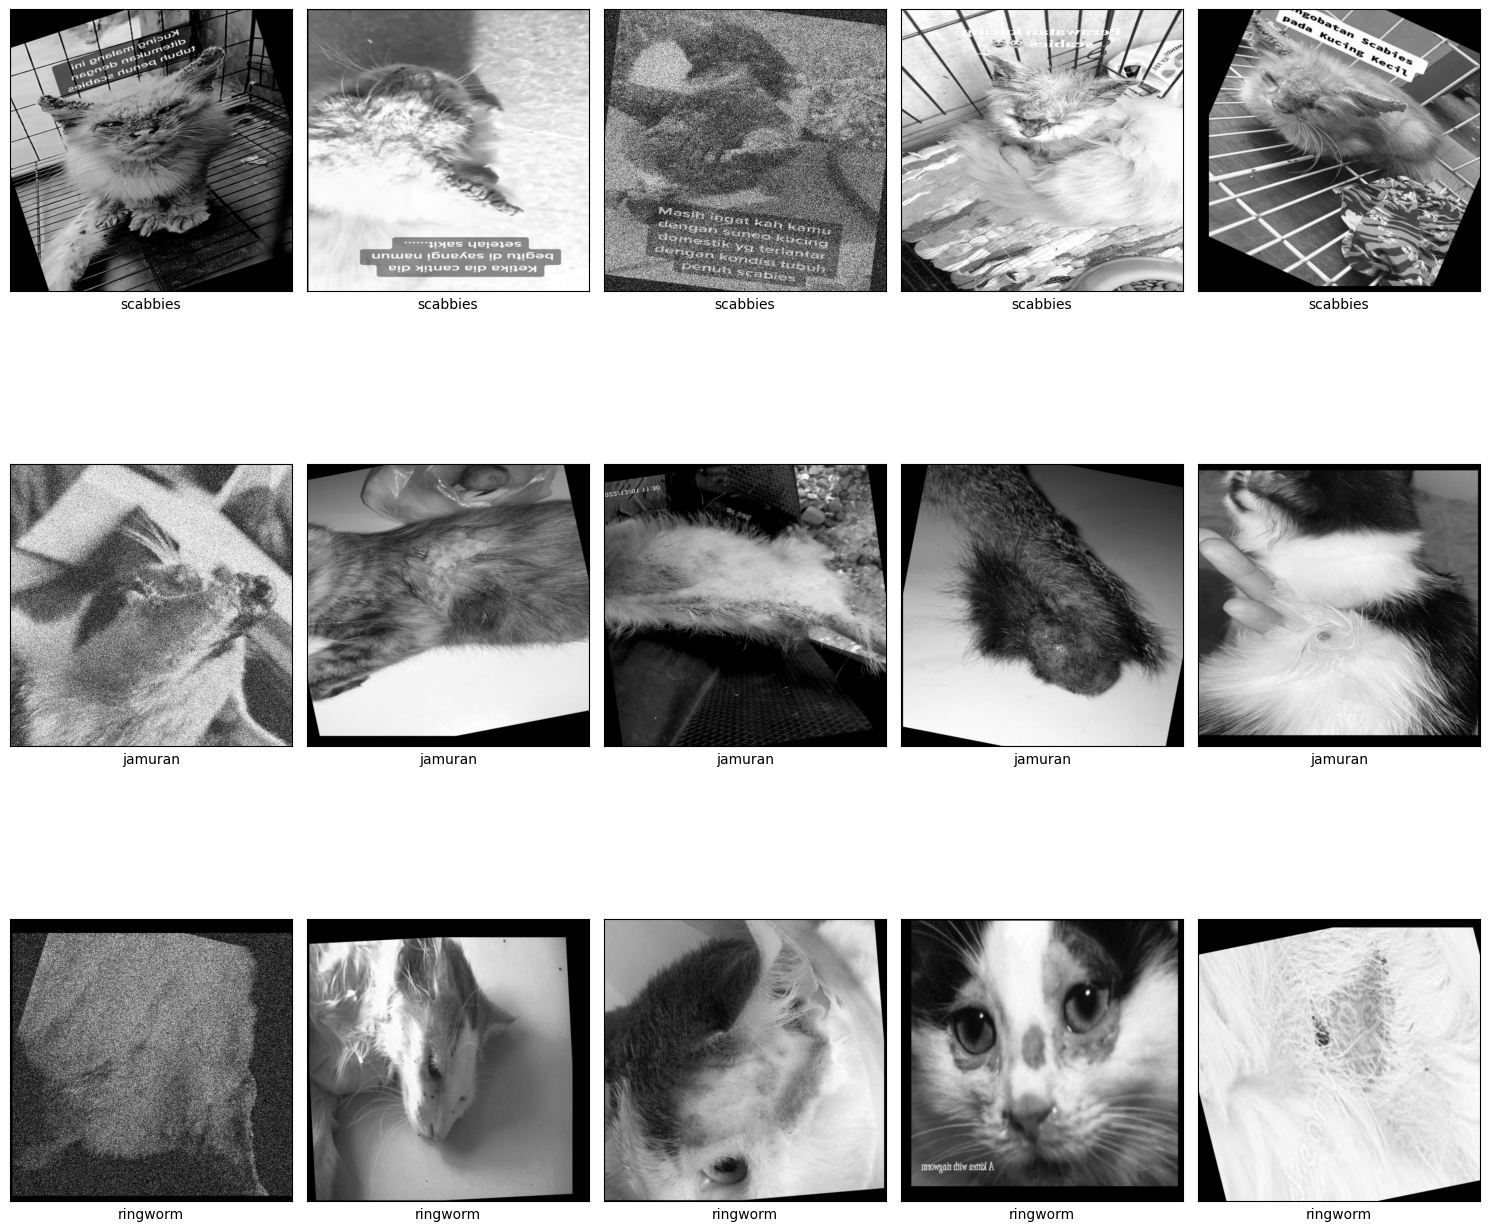

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = dataset
for i in os.listdir(path):
    lung_image[i] = os.listdir(os.path.join(path, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = dataset

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

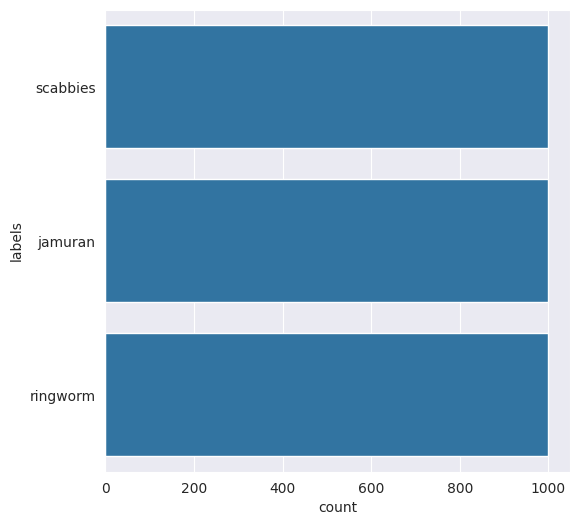

In [ ]:
# Definisikan path sumber
lung_path = dataset

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
# Path to the data directory
data_dir = dataset

# Initialize a counter for the number of images
image_count = 0

# Iterate through all subdirectories and files in the data directory
for root, _, files in os.walk(data_dir):
  # Iterate through all files in the current directory
  for file in files:
    # Check if the file is an image (you might want to add more image extensions)
    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
      image_count += 1

# Print the total number of images
print(f"Total number of images in the 'data' folder: {image_count}")


Total number of images in the 'data' folder: 3000


### Data Preprocessing

#### Split Dataset

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= dataset

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
jamuran,1000
ringworm,1000
scabbies,1000


In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 2400
test size 600


In [ ]:
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

df_train = pd.DataFrame({'path': X_train_final, 'labels': y_train_final, 'set': 'train'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'val'})

In [ ]:
print('val size', len(df_val))

val size 480


## Modelling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout
import tensorflow as tf

num_classes = 3  # Ganti sesuai jumlah kelas kamu

model_1 = Sequential()

model_1.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(160,160,3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Conv2D(64, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
# model_1.add(Dense(num_classes))
# model_1.add(Dropout(0.3))

# Ubah output layer untuk multi-class
model_1.add(Dense(num_classes, activation='softmax'))

# Compile pakai sparse_categorical_crossentropy kalau label angka biasa
model_1.compile(optimizer="Adam",
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

print(model_1.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 160, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,218,787 (50.43 MB)

 Trainable params: 13,218,563 (50.42 MB)

 Non-trainable params: 224 (896.00 B)

None


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Hitung class weight berdasarkan label training akhir
class_labels = np.unique(y_train_final)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=y_train_final
)

# Konversi jadi dictionary (keras pakainya seperti ini)
class_weights = dict(zip(class_labels, class_weights_array))

print("Class Weights:", class_weights)


Class Weights: {'jamuran': np.float64(1.0062893081761006), 'ringworm': np.float64(1.0094637223974763), 'scabbies': np.float64(0.9846153846153847)}


In [ ]:
from PIL import Image
import numpy as np

def load_images(paths, target_size=(160, 160)):
    images = []
    for path in paths:
        try:
            img = Image.open(path).resize(target_size).convert('RGB')
            images.append(np.array(img))
        except Exception as e:
            print(f"Error loading {path}: {e}")
    return np.array(images)


In [ ]:
# Ambil list path dari DataFrame
X_train_final = df_train['path'].values
y_train_final = df_train['labels'].values

X_val = df_val['path'].values
y_val = df_val['labels'].values

# Load gambar dari path jadi array
X_train_images = load_images(X_train_final)
X_val_images = load_images(X_val)

# Normalisasi
X_train_images = X_train_images / 255.0
X_val_images = X_val_images / 255.0


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Inisialisasi dan fit encoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_final)
y_val_encoded = label_encoder.transform(y_val)


In [ ]:
history =   model_1.fit(X_train_images, y_train_encoded,
            validation_data=(X_val_images, y_val_encoded),
            epochs=30,
            class_weight=class_weights)


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9617 - loss: 0.1308 - val_accuracy: 0.8354 - val_loss: 0.8269
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9631 - loss: 0.1117 - val_accuracy: 0.7750 - val_loss: 1.2367
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9638 - loss: 0.0937 - val_accuracy: 0.6896 - val_loss: 2.5404
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9686 - loss: 0.0980 - val_accuracy: 0.8042 - val_loss: 0.9779
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9606 - loss: 0.1167 - val_accuracy: 0.7917 - val_loss: 0.9850
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9480 - loss: 0.1707 - val_accuracy: 0.7250 - val_loss: 2.0062
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9670 - loss: 0.1118 - val_accuracy: 0.8313 - val_loss: 0.8796
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9667 - loss: 0.1133 - val_accuracy: 0.8354 - v

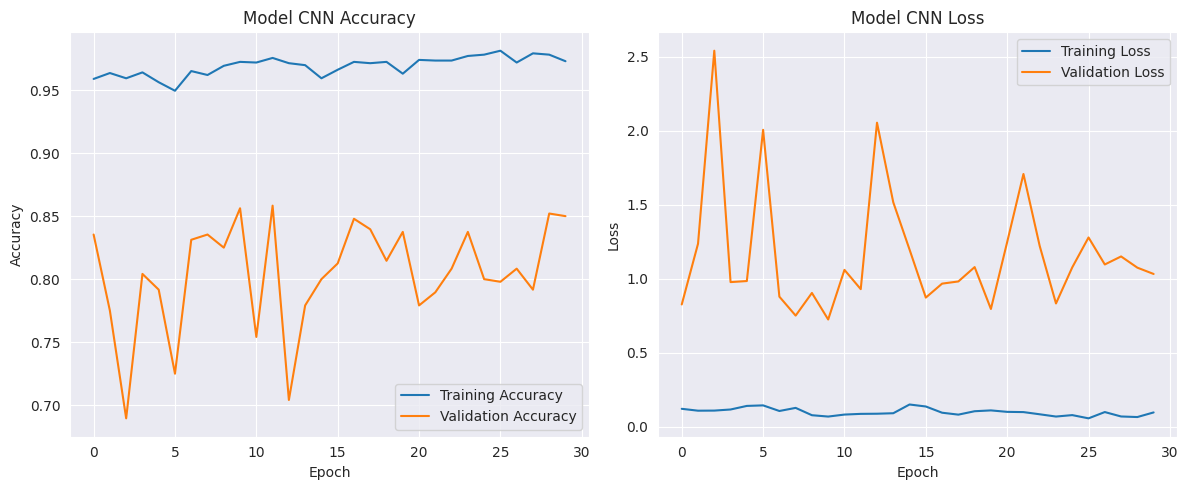

In [ ]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG16 tanpa fully connected layer di atas (include_top=False)
model_2 = VGG16(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

# Bekukan layer awal (agar tidak dilatih ulang)
for layer in model_2.layers:
    layer.trainable = False

# Tambahkan custom classification head di atasnya
x = Flatten()(model_2.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)  # misal untuk klasifikasi 10 kelas

model_2 = Model(inputs=model_2.input, outputs=x)

# Compile model
model_2.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Ringkasan model
model_2.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 160, 160, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 160, 160, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 40, 40, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 20, 20, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,270,339 (81.14 MB)

 Trainable params: 6,555,651 (25.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history=model_2.fit(X_train_images, y_train_encoded,
            validation_data=(X_val_images, y_val_encoded),
            epochs=30,
            class_weight=class_weights)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - accuracy: 0.3871 - loss: 1.2443 - val_accuracy: 0.6167 - val_loss: 0.8814
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.5325 - loss: 0.9521 - val_accuracy: 0.6854 - val_loss: 0.7685
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.6469 - loss: 0.7894 - val_accuracy: 0.7104 - val_loss: 0.7107
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.6715 - loss: 0.7384 - val_accuracy: 0.7271 - val_loss: 0.6741
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.7100 - loss: 0.6572 - val_accuracy: 0.7167 - val_loss: 0.6429
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.7389 - loss: 0.6073 - val_accuracy: 0.7521 - val_loss: 0.6153
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.7561 - loss: 0.5714 - val_accuracy: 0.7604 - val_loss: 0.5981
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.7847 - loss: 0.5296 - val_accuracy

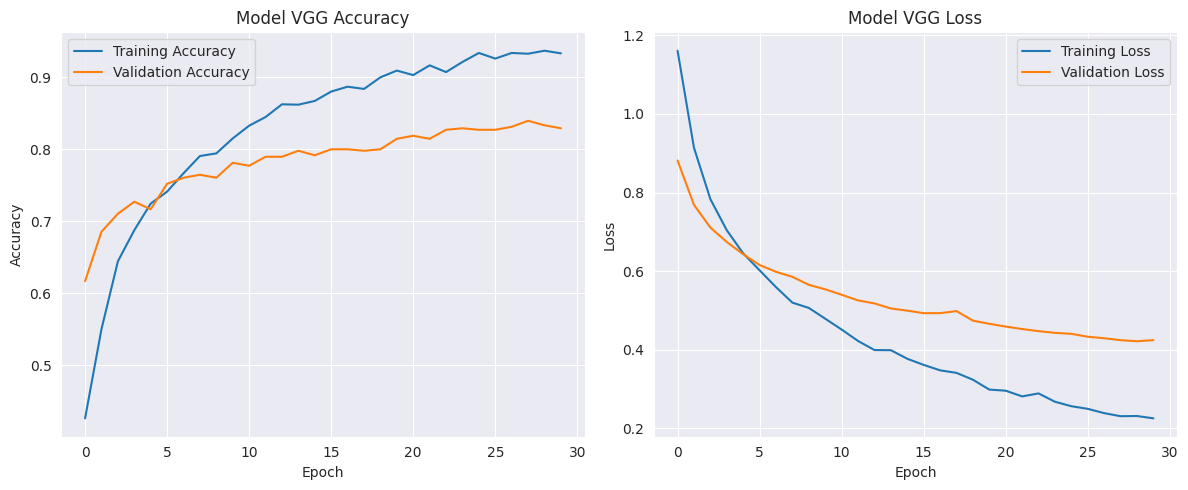

In [ ]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model VGG Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model VGG Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluasi dan Visualisasi

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# Ukuran gambar sesuai dengan input model
img_size = (160, 160)

def preprocess_image(img_path):
    img = load_img(img_path, target_size=img_size)
    img = img_to_array(img)
    img = img / 255.0  # Normalisasi
    return img

# Preprocess seluruh X_test
X_test_arr = np.array([preprocess_image(path) for path in df_te['path']])
y_test_arr = df_te['labels'].values


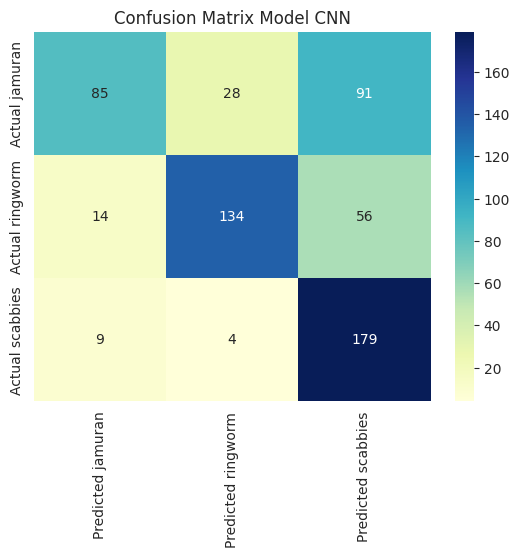


Classification Report:

              precision    recall  f1-score   support

     jamuran     0.7870    0.4167    0.5449       204
    ringworm     0.8072    0.6569    0.7243       204
    scabbies     0.5491    0.9323    0.6911       192

    accuracy                         0.6633       600
   macro avg     0.7144    0.6686    0.6534       600
weighted avg     0.7178    0.6633    0.6527       600



In [ ]:
# Prediksi
y_pred_probs = model_1.predict(X_test_arr, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Konversi label string jadi angka kalau perlu
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test_arr)

# Confusion matrix dan classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

labels = le.classes_

cm = pd.DataFrame(confusion_matrix(y_test_encoded, y_pred),
                  index=[f'Actual {l}' for l in labels],
                  columns=[f'Predicted {l}' for l in labels])

sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix Model CNN')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test_encoded, y_pred, target_names=labels, digits=4))


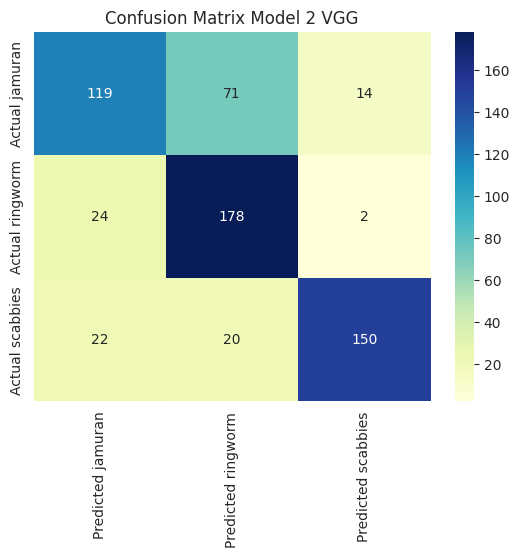


Classification Report:

              precision    recall  f1-score   support

     jamuran     0.7212    0.5833    0.6450       204
    ringworm     0.6617    0.8725    0.7526       204
    scabbies     0.9036    0.7812    0.8380       192

    accuracy                         0.7450       600
   macro avg     0.7622    0.7457    0.7452       600
weighted avg     0.7594    0.7450    0.7434       600



In [ ]:
# Prediksi
y_pred_probs = model_2.predict(X_test_arr, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Konversi label string jadi angka kalau perlu
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test_arr)

# Confusion matrix dan classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

labels = le.classes_

cm = pd.DataFrame(confusion_matrix(y_test_encoded, y_pred),
                  index=[f'Actual {l}' for l in labels],
                  columns=[f'Predicted {l}' for l in labels])

sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix Model 2 VGG')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test_encoded, y_pred, target_names=labels, digits=4))


## Konversi Model

In [ ]:
# Install TensorFlow.js converter
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
model_1.export('cat_skin_disease_Model')

Saved artifact at 'cat_skin_disease_Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_368')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138762341725776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138762341725008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138762341727888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138762341727312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138762341726736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138762341720400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138762735126288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138762341719056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138762341726544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138761037464208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1387

In [ ]:
model_2.export('cat_skin_disease_Model')

Saved artifact at 'cat_skin_disease_Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_92')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137375627260560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137375627262864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137375627258256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137375627260176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137375627263056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137375604395088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137375604394704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137375604393360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137375604394512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137375604392784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13737

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --saved_model_tags=serve \
    /content/cat_skin_disease_Model \
    /content/cat_skin_disease_Model_tfjs

2025-05-02 02:18:28.070029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746152308.108792   11684 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746152308.119122   11684 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-02 02:18:35.233598: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1746152315.233752   11684 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
# Load model dari SavedModel format
converter = tf.lite.TFLiteConverter.from_saved_model('/content/cat_skin_disease_Model')

# Konversi ke TFLite
tflite_model = converter.convert()

# Simpan ke file .tflite
with open('/content/cat_skin_disease_Model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
# prompt: download /content/cat_skin_disease_Model.tflite

from google.colab import files
files.download('/content/cat_skin_disease_Model.tflite')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

Saving Image_57_jpg.rf.58acf0eaf3533b1dfd3888b9657827e3.jpg to Image_57_jpg.rf.58acf0eaf3533b1dfd3888b9657827e3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


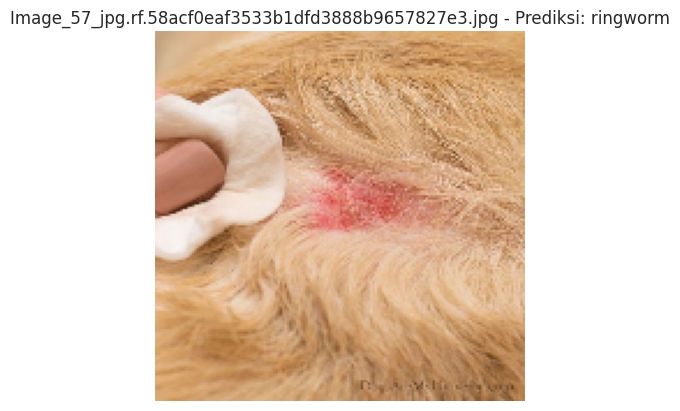

Image_57_jpg.rf.58acf0eaf3533b1dfd3888b9657827e3.jpg ➜ Diprediksi sebagai: ringworm


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Kelas target (harus sesuai urutan output layer model)
class_names = ['jamuran', 'ringworm', 'scabbies']  # ganti sesuai label kamu

# Upload file dari lokal
uploaded = files.upload()

# Loop semua gambar yang di-upload
for fn in uploaded.keys():
    # Load dan preprocess gambar
    img_path = fn
    img = image.load_img(img_path, target_size=(160, 160))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalisasi

    # Prediksi dengan model
    predictions = model_1.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # Tampilkan gambar dan hasil prediksi
    plt.imshow(img)
    plt.title(f'{fn} - Prediksi: {predicted_class}')
    plt.axis('off')
    plt.show()

    print(f"{fn} ➜ Diprediksi sebagai: {predicted_class}")
